In [1]:
import pandas as pd
import numpy as np
import json

In [ ]:
sessions = pd.read_csv('sessions.csv', index_col=1)

Получим распределение количества треков у каждого пользователя

In [ ]:
count_play = {}
for i, line in sessions.iloc[:,1].iteritems():
  spt = line.split()
  count_play[i] = json.loads(spt[0])['numtracks']


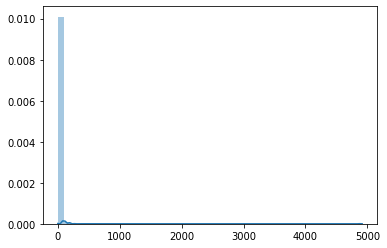

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.distplot(list(count_play.values()))
#plt.xlim(0,30000)

In [ ]:
np.percentile(list(count_play.values()), 95)

39.0

можно ограничится только 40 треками

In [ ]:
sessions = sessions.drop(columns=['0'], axis = 1)

In [ ]:
sessions.head()

,2,3
1,,
287144,1390231051,"{""numtracks"":23,""playtime"":4547} {""subjects"":[..."
287145,1390241844,"{""numtracks"":11,""playtime"":2907} {""subjects"":[..."
287146,1390303249,"{""numtracks"":16,""playtime"":3191} {""subjects"":[..."
287147,1390481828,"{""numtracks"":5,""playtime"":1162} {""subjects"":[{..."
287140,1421443687,"{""numtracks"":2,""playtime"":250} {""subjects"":[{""..."


In [ ]:
from tqdm import tqdm, tqdm_notebook

Получим информацию о id пользователя, номере эвента, сессии, id трека и количестве прослушиваний

In [ ]:
user_id = []
event = []
session = []
track_id = []
playtime = []
for i, line in tqdm(sessions.iterrows()):
  spt = line[1].split()
  numtracks = json.loads(spt[0])['numtracks']
  if numtracks < 40:
    session.extend([line[0]] * numtracks)
    event.extend([i] * numtracks)
    user_id.extend([json.loads(spt[1])['subjects'][0]['id']] * numtracks)
    
    for obj in json.loads(spt[1])["objects"]:
      track_id.append(obj['id'])
      playtime.append(obj['playtime'])

2764474it [08:56, 5156.13it/s]


In [ ]:
sessions = pd.DataFrame(zip(user_id, session, event, track_id, playtime), columns = ['user_id', 'session', 'event', 'track_id', 'playtime'])

In [ ]:
sessions.head()

,user_id,session,event,track_id,playtime
0,44361,1390231051,287144,4698874,58
1,44361,1390231051,287144,838286,310
2,44361,1390231051,287144,2588097,179
3,44361,1390231051,287144,2746740,342
4,44361,1390231051,287144,3873988,259


In [ ]:
sessions.shape

(21217009, 4)

Сохраним все

In [ ]:
sessions.to_csv('new_sessions.csv', index = False)

In [ ]:
sessions = pd.read_csv('new_sessions.csv')

Так как после различных проб использование сессиии и эвент оказалось бесполезным, их необходимо удалить

In [ ]:
sessions = sessions.drop(['event', 'session'], axis = 1)

In [ ]:
sessions.head()

,user_id,track_id,playtime
0,44361,4698874,58
1,44361,838286,310
2,44361,2588097,179
3,44361,2746740,342
4,44361,3873988,259


Так как для каждой сессии есть повторяющиеся треки, то нужно посчитать общее количество прослушиваний 

In [ ]:
trans = sessions.groupby(['user_id','track_id'])['playtime'].transform('sum')
sessions['playtime'] = trans

In [ ]:
trans = sessions.groupby(by = 'user_id')['track_id'].apply(pd.Series.drop_duplicates)

In [ ]:
trans.head()

user_id        
1        867353    3327773
         867354      82832
         867355    1559353
         867356    1558953
         867357    1559198
Name: track_id, dtype: int64

In [ ]:
true_ind = [ind[1] for ind in trans.index]

In [ ]:
no_dupl = sessions.loc[true_ind]

In [ ]:
no_dupl.to_csv('no_dupl.csv', index = False)

In [ ]:
sessions = pd.read_csv('no_dupl.csv')

In [ ]:
tracks = pd.read_csv('tracks.csv')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (1,5,8) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
tracks = tracks.rename(columns={'1':'track_id'}) 

In [ ]:
tracks.head()

,track_id,MBID,duration,name,playcount,albums,artists_id,artists_type,tags
0,0,NaN,-1.0,000003+Music+Instructor/_/Dj%27s+Rock+Da+House...,4.0,[],0,person,[]
1,1,NaN,-1.0,00-01/_/%D0%A2%D0%B5%D0%BA%D1%81%D1%82,495.0,[],1,person,[]
2,2,NaN,-1.0,0005.+Overkill/_/Overkill,2.0,[],2,person,[]
3,3,NaN,-1.0,000C+Tony+Dize/_/Ruleta+Rusa,2.0,[],3,person,[]
4,4,NaN,-1.0,000+Oscarcito/_/Tumbay%E2%80%9A+(Lyrics),1.0,[],4,person,[]


Теги тоже не было понятно, как использовать, так что они были удалены

In [ ]:
tracks.tags.value_counts()

[]                                                                                                                                                             2724881
[{'type': 'tag', 'id': 205245}]                                                                                                                                   6720
[{'type': 'tag', 'id': 122769}]                                                                                                                                   4628
[{'type': 'tag', 'id': 83064}]                                                                                                                                    4370
[{'type': 'tag', 'id': 189631}]                                                                                                                                   3503
                                                                                                                                                                ...  

Для каждого трека был поставлен в соответвие автор

In [ ]:
sessions = sessions.merge(tracks[['artists_id', 'track_id']], on = 'track_id')

In [ ]:
del tracks

In [ ]:
import gc
gc.collect()

25

In [ ]:
sessions.head()

,user_id,track_id,playtime,artists_id
0,1,3327773,285,413070
1,648,3327773,575,413070
2,5861,3327773,288,413070
3,7395,3327773,311,413070
4,11928,3327773,146,413070


In [ ]:
sessions.shape

(21327523, 4)

In [ ]:
sessions.isna().sum()

user_id       0
track_id      0
playtime      0
artists_id    0
dtype: int64

Теперь необходимо посчитать общее количество прослушиваний артиста

In [ ]:
trans = sessions.groupby(['user_id','artists_id'])['playtime'].transform('sum')
sessions['playtime'] = trans
trans = sessions.groupby(by = 'user_id')['artists_id'].apply(pd.Series.drop_duplicates)

In [ ]:
true_ind = [ind[1] for ind in trans.index]
no_dupl = sessions.loc[true_ind]

In [ ]:
no_dupl[no_dupl['user_id'] == 44361]['artists_id'].value_counts()

48127     1
300373    1
541011    1
541010    1
541009    1
         ..
74413     1
120490    1
255657    1
303781    1
237568    1
Name: artists_id, Length: 606, dtype: int64

In [ ]:
no_dupl.to_csv('new_sessions_wh_tracks.csv', index = False)

In [8]:
sessions = pd.read_csv('new_sessions_wh_tracks.csv')

In [9]:
sessions.head()

,user_id,track_id,playtime,artists_id
0,1,3327773,285,413070
1,1,82832,6350,11467
2,1,1559353,6105,195697
3,1,2424490,24486,303270
4,1,149854,7528,19627


In [10]:
sessions.shape

(5002346, 4)

Размер таблицы стал слишком большим, необходимо удалить слишком редких артистов

In [11]:
artist_playtime = sessions.groupby(by = 'artists_id')['playtime'].apply(sum)
artist_playtime = artist_playtime[artist_playtime>0]
sorted_artist = artist_playtime.sort_values()
print(sorted_artist[-7000:].sum()/sorted_artist.sum())
most_famous = sorted_artist[-7000:].index.values

0.7820220471928309


In [12]:
sessions = sessions[sessions['artists_id'].isin(most_famous)]

In [13]:
sessions.shape

(2912767, 4)

In [14]:
sessions.to_csv('cuted_sessions.csv', index = False)

Идея составления рекомендаций: чем чаще одного артиста слушают вместе с другим, тем с большей вероятностью его можно порекомендовать

In [8]:
pair_dict = {}
art_unq = sorted(sessions.artists_id.unique())
i = 0
for artist_one in art_unq:
  for artist_two in art_unq[i:]:
    pair_dict[artist_one, artist_two] = 0
  i = i + 1

In [9]:
len(pair_dict)

24503500

In [10]:
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [11]:
def update(dictionary, key_artist, other_artist, artists_vals):
  keys = tuple(zip([key_artist]*len(other_artist), other_artist))
  old_val = np.array([dictionary.get(key) for key in keys])
  artists_vals = old_val + artists_vals
  dictionary.update(dict(zip(keys, artists_vals)))

In [12]:
def data_to_update(data, dictionary):
  for num in range(len(data)):
    key_artist = data['artists_id'].iloc[num]
    other_artists = data['artists_id'].iloc[num:]
    artists_val = data['playtime'].iloc[num:]
    update(dictionary, key_artist, other_artists, np.array(artists_val))

In [13]:
unq_user = sessions.user_id.unique()

for user in tqdm(unq_user):
  cur_session = sessions[sessions['user_id'] == user]
  if cur_session.shape[0] > 1:
    train, test = train_test_split(cur_session,
                    test_size=0.2, random_state=17)
    
    train = train.sort_values(by = 'artists_id')
    test = test.sort_values(by = 'artists_id')
    data_to_update(train, pair_dict)

100%|████████████████████████████████████████████████████████████████████████████| 44457/44457 [25:41<00:00, 28.84it/s]


Сохраним полученые пары

In [14]:
import pickle
with open('train_dict.pickle', 'wb') as f:
  pickle.dump(pair_dict, f)

In [2]:
import pickle
with open('train_dict.pickle', 'rb') as f:
    train_dic = pickle.load(f)

In [5]:
sessions = pd.read_csv('cuted_sessions.csv')

In [6]:
sessions.head()

,user_id,track_id,playtime,artists_id
0,1,82832,6350,11467
1,1,1559353,6105,195697
2,1,2424490,24486,303270
3,1,149854,7528,19627
4,1,83948,3896,11617


Теперь нужно для каждого пользователя составить рекомендации. Работает это следующим образом: для каждого артиста из списка прослушанных пользователем выбирается наиболее вероятная пара, таким образом имеем len(train) предложенных артистов, этот список сортируется по величине вероятности и len(test) из них выбирается в качестве предложенных

In [3]:
def get_max_pair(dictionary, keys):
    max_val = dictionary[keys[0]]
    max_key = keys[0][1]
    for key in keys:
        if dictionary.get(key) > max_val:
            max_val = dictionary.get(key)
            max_key = key[1]
    return max_key, max_val

In [4]:
def predict(data, dictionary, len_test):
    max_val_list = []
    for num in range(len(data)):
        key_artist = data['artists_id'].iloc[num]
        other_artists = data['artists_id'].iloc[num:]
        keys = tuple(zip([key_artist]*len(other_artists), other_artists))
        max_val_list.append(get_max_pair(dictionary, keys))
    max_val_list.sort(key=operator.itemgetter(1))
    predictions = [artist_pair[0] for artist_pair in max_val_list[:len_test]]
    return predictions

In [7]:
from sklearn.metrics import ndcg_score,roc_auc_score
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import operator

Для оценки качества выбрана метрика РОК-аук, так как рекомендации - это задача многоклассовой классификации

In [40]:
from sklearn.preprocessing import MultiLabelBinarizer
def multiclass_roc_auc_score(all_artist, y_test, y_pred, average="macro"):
    lb = MultiLabelBinarizer()
    lb.fit([all_artist['artists_id'].values])
    y_test = lb.transform([y_test])
    y_pred = lb.transform([y_pred])
    return roc_auc_score(y_test[0], y_pred[0], average=average)

In [47]:
unq_user = sessions.user_id.unique()
user_score = dict(zip(unq_user, [0]*len(unq_user)))
for user in tqdm(unq_user):
    cur_session = sessions[sessions['user_id'] == user]
    if cur_session.shape[0] > 10:
        train, test = train_test_split(cur_session,
                                       test_size=0.2, random_state=17)
        train = train.sort_values(by = 'artists_id')
        test = test.sort_values(by = 'artists_id')
        predicts = sorted(predict(train, train_dic, len(test)))
        #score = roc_auc_score(test.artists_id.values, np.array(predicts), multi_class = 'ovo')
        score = multiclass_roc_auc_score(cur_session, test.artists_id, predicts)
        user_score[user] = score

100%|████████████████████████████████████████████████████████████████████████████| 44457/44457 [14:35<00:00, 50.79it/s]


In [101]:
with open('score_dict.pickle', 'wb') as f:
    pickle.dump(user_score, f)

mean score: 0.33


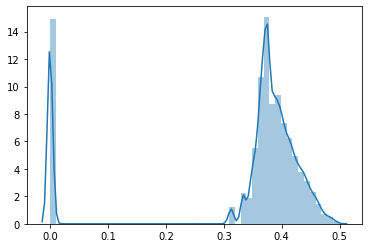

In [48]:
import seaborn as sns
score = np.array(list(user_score.values()))
print("mean score: %.2f" %score.mean())
sns.distplot(score)

Интересно понять, в каком случае получается нулевая точность

In [117]:
zero_score = {k for k, v in user_score.items() if v < 0.05}

In [118]:
zero_user = sessions[sessions['user_id'].isin(zero_score)] 

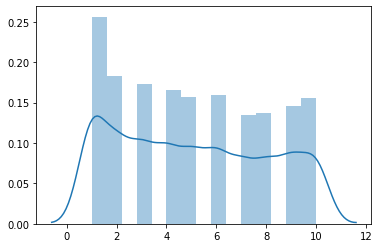

In [124]:
sns.distplot(zero_user.groupby(by = 'user_id').apply(len))

Как видно, нулевой скор получается у пользователей, которые не послушали достаточно большое количество артистов

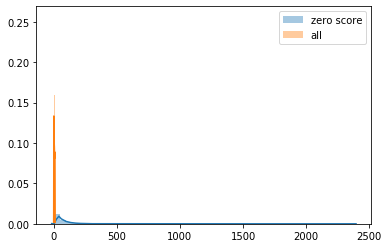

In [127]:
import matplotlib.pyplot as plt
sns.distplot(sessions.groupby(by = 'user_id').apply(len), label = 'zero score')
sns.distplot(zero_user.groupby(by = 'user_id').apply(len), label = 'all')
plt.legend();

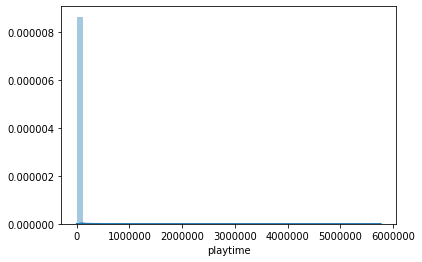

In [111]:
sns.distplot(zero_user.playtime)